# Recap of lecture on the standard incomplete markets model steady state

NBER Heterogeneous-Agent Macro Workshop

Matthew Rognlie

Spring 2023

# Standard incomplete markets model
- Come in with assets including return $(1+r)a$ and stochastic income $y(e)$
- Allocate to assets for tomorrow $a'$ and consumption today $c$
- ... all subject to a borrowing constraint $a'\geq \underline{a}$ and no ability to insure against the shock $e$


$$
\begin{gather}
V(e,a)=\max_{c,a'} u(c)+\beta\mathbb{E}[V(e',a')|e] \tag{1}\\
\text{s.t. }a'+c=(1+r)a+y(e) \tag{2}\\
a'\geq \underline{a} \tag{3} \\
\end{gather}
$$

- (aka Bewley-Huggett-Aiyagari-Imrohoroglu-Zeldes-Deaton-Carroll model)

# Nice features of this model
- Simple consumption-savings model with consumption smoothing and precautionary savings


- High MPCs


- Endogenously generates wealth distribution (and inequality)


- Steady-state asset demand not infinitely elastic in $r$


- Easy to extend
    
    
- **Backbone of everything we'll do!**

# Solving the model in steady state
Four steps, middle two the hardest:

1. **Discretizing state space**: get Markov chain for $e$ and grid for $a$


2. **Solving for steady-state policy function**: get policies $a'(e,a)$ and $c(e,a)$ on grid
    - Use "endogenous gridpoints method" to iterate backward on marginal value function $V_a(e,a)$ until we reach steady state


3. **Solving for steady-state distribution**: get discretized distribution $D(e,a)$ of agents on grid
    - Convert asset choices $a'$ into "lotteries" between adjacent gridpoints that give $a'$ on average, then use this approximation to iterate forward on $D(e,a)$ until we reach steady state


4. **Aggregating**: combine steps 2 and 3 to get aggregate assets and consumption

# All boiled down into one Python module
All our code from lecture boiled down into `sim_steady_state.py`, refined slightly in `sim_steady_state_fast.py`, which doubles speed

In [1]:
import sim_steady_state_fast as sim

Other Python libraries:

In [2]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

# some useful plot defaults
plt.rcParams.update({'font.size' : 20, 'lines.linewidth' : 3.5, 'figure.figsize' : (13,7)})

# Calibration: choose parameters (e.g. $\beta$) to hit targets
Our methods compute steady state of standard incomplete markets model given parameters, e.g.

In [3]:
calib = sim.example_calibration()
calib.keys()

dict_keys(['a_grid', 'y', 'Pi', 'r', 'beta', 'eis'])

In [4]:
ss = sim.steady_state(**calib)
ss['A']

1.6645070661939911

But an alternative is to choose some parameters (for instance, $\beta$) to hit some targets (for instance, total assets equal to 5.6, or 1.4 times annual income):

In [5]:
beta_calib = optimize.brentq(
                lambda beta: sim.steady_state(**{**calib, 'beta': beta})['A'] - 5.6,
                0.98, 0.995)
ss = sim.steady_state(**{**calib, 'beta': beta_calib})
beta_calib, ss['A']

(0.9877039403543708, 5.599999999969482)

# General equilibrium
Embed partial equilibrium standard incomplete markets in simple general equilibrium setting:
- Households have endowments $e$ of effective labor, which produce goods one-for-one



- Government issues debt $B$ and finances with tax $\tau=rB$, households earn $y(e)=(1-\tau)e$


Calibrate to same asset target:

In [6]:
calib = sim.example_calibration()
B = 5.6
tau = calib['r']*B
calib['y'] *= (1-tau)
beta_ge = optimize.brentq(lambda beta: sim.steady_state(**{**calib, 'beta': beta})['A'] - B, 0.98, 0.995)
ss_ge = sim.steady_state(**{**calib, 'beta': beta_ge})

Asset and goods market clearing:

In [7]:
ss_ge['A'] - B, ss_ge['C'] - 1

(-1.660449555629384e-11, 3.802775649930368e-09)

# General equilibrium counterfactuals
Vary some parameter of model, then recalculate $r$ to satisfy asset market clearing.

Here, let's change standard deviation of income:

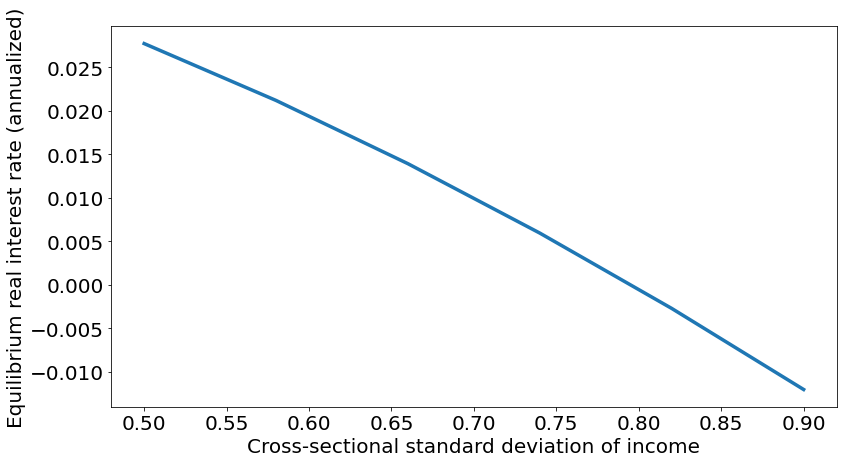

In [8]:
sigmas = np.linspace(0.5, 0.9, 6) # our benchmark was sigma=0.7
rs = []
for sigma in sigmas:
    e, pi, Pi = sim.discretize_income(0.975, sigma, 7)
    rs.append(optimize.brentq(
                lambda r: sim.steady_state(**{**calib, 'y': (1-r*B)*e, 'r': r, 'beta': beta_ge, 'Pi': Pi})['A'] - B,
                -0.02, 0.01))
plt.plot(sigmas, 4*np.array(rs))
plt.xlabel('Cross-sectional standard deviation of income')
plt.ylabel('Equilibrium real interest rate (annualized)');

(Minor side note: using a narrower range of $\sigma$ here, since the larger range in original lecture required more forward iterations than `sim_steady_state` code allows by default.)

# Expectation functions
- For any function $x(e,a)$, ask: if the state is $(e_t,a_t)$ today, what do we expect $x(e_{t+j},a_{t+j})$ to be, assuming household follows steady-state policy rule?


- Call this the $j$th **expectation function** $\mathcal{E}_j$, easily calculated using law of iterated expectations and code for one-period-ahead expectation:

$$
\mathcal{E}_j(e,a) \equiv \mathbb{E}[x(e_{t+j}, a_{t+j}) | (e_t, a_t)]
$$
    

- For instance, expectation function of assets, for household with zero assets but high income today:

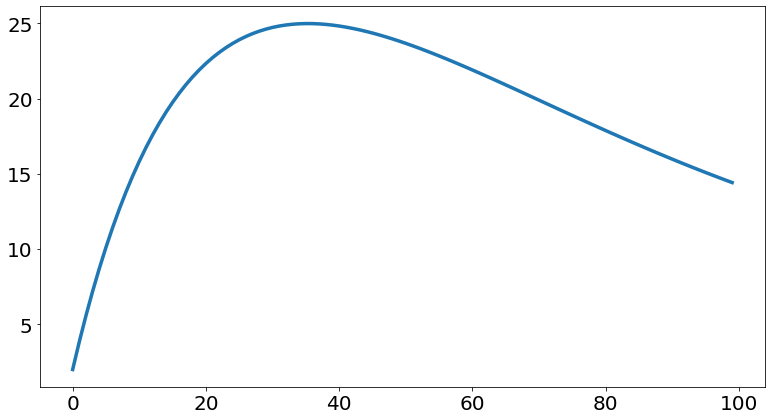

In [9]:
curlyE = sim.expectation_functions(ss['a'], ss['Pi'], ss['a_i'], ss['a_pi'], 100)
plt.plot(curlyE[:, -1, 0]);